In [1]:
from pathlib import Path
import os
import pandas as pd
import json
import matplotlib.pyplot as plt

In [38]:
def get_results(path="/mnt/c/github/explainabloomity/results"):
    models = ("opt-13b", )
    prune_methods=(
        "balanced",
        "balanced_mask",
        "imbalanced",
        "imbalanced_mask",
        # "r_mask" is not needed as a general prune method because it's specific to the new path
    )
    metrics=(
        "cosine_cosine",
        "euclidean_euclidean",
        "cosine_random",
        "euclidean_random",
    )
    prunetasks=(
        "paws_en",
        "hellaswag",
        "arc_easy",
        "blimp_ellipsis_n_bar_1",
    )
    prune_percents=(
        "0.25",
        "0.5",
        "0.75",
    )
    tasks=(
        "lambada_openai",
        "paws_en",
        "hellaswag",
        "arc_easy",
        "blimp_ellipsis_n_bar_1",
        "blimp_irregular_plural_subject_verb_agreement_1")
    rows = []
    for model in models:
        for prune_method in prune_methods:
            for prune_task in prunetasks:
                for prune_metric in metrics:
                    for task in tasks:
                        for prune_percent in prune_percents:
                            # Default path format
                            path_model = Path("./results") / task / model / prune_method / prune_task / prune_metric / prune_percent / "results.json"
                            if path_model.exists():
                                with open(path_model, "r", encoding='utf-8') as f:
                                    data = json.load(f)
                                    norm_accuracy = 1- data["results"][task]["acc,none"] if task == "paws_en" else data["results"][task]["acc,none"]
                                    row = {
                                        "model": model, 
                                        "prune_method": prune_method, 
                                        "prune_task": prune_task, 
                                        "metric": prune_metric, 
                                        "percent": float(prune_percent), 
                                        "task": task, 
                                        "norm_accuracy": norm_accuracy
                                    }
                                    rows.append(row)
                        # Add base model results
                        base_model = model + "_base"
                        path_model_base = Path("./results") / task / base_model / "results.json"
                        if path_model_base.exists():
                            with open(path_model_base, "r") as f:
                                data = json.load(f)
                                norm_accuracy = 1- data["results"][task]["acc,none"] if task == "paws_en" else data["results"][task]["acc,none"]
                                row = {
                                    "model": model, 
                                    "prune_method": prune_method, 
                                    "prune_task": prune_task, 
                                    "metric": prune_metric, 
                                    "percent": 0.0, 
                                    "task": task, 
                                    "norm_accuracy": norm_accuracy
                                }
                                rows.append(row)
    # Check the special path with "r_mask/r/r"
    for model in models:
        for task in tasks:
            for prune_percent in prune_percents:
                path_model = Path("./results") / task / model / "r_mask" / "r" / "r" / prune_percent / "results.json"
                if path_model.exists():
                    with open(path_model, "r", encoding='utf-8') as f:
                        data = json.load(f)
                        norm_accuracy = 1- data["results"][task]["acc,none"] if task == "paws_en" else data["results"][task]["acc,none"]
                        row = {
                            "model": model, 
                            "prune_method": "r_mask", 
                            "prune_task": "r", 
                            "metric": "r", 
                            "percent": float(prune_percent), 
                            "task": task, 
                            "norm_accuracy": norm_accuracy
                        }
                        rows.append(row)

                base_model = model + "_base"
                path_model_base = Path("./results") / task / base_model / "results.json"
                if path_model_base.exists():
                    with open(path_model_base, "r") as f:
                        data = json.load(f)
                        norm_accuracy = 1- data["results"][task]["acc,none"] if task == "paws_en" else data["results"][task]["acc,none"]
                        row = {
                            "model": model, 
                            "prune_method": "r_mask", 
                            "prune_task": "r", 
                            "metric": "r", 
                            "percent": 0.0, 
                            "task": task, 
                            "norm_accuracy": norm_accuracy
                        }
                        rows.append(row)

    df = pd.DataFrame(rows)
    return df

def load_amazon_results(directory='results/opt-13b_amazon'):
    rows =[]
    # Directory names are like '0shot_arc_easy', '0shot_hellaswag', etc.
    for dir_name in os.listdir(directory):
        dir_path = os.path.join(directory, dir_name)
        if os.path.isdir(dir_path):
            # File names are like '0shot_25percent', '0shot_50percent', etc.
            for file_name in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file_name)
                try:
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                        # Extract pruning percentage from file name
                        pruning_percent = file_name.split('_')[1].replace('percent', '')
                        # Store data based on dir_name and pruning percent
                        for dataset, metrics in data['results'].items():
                            if 'acc' in metrics:
                                task = 'lambada_openai' if dataset == 'lambada' else dataset
                                norm_accuracy = 1 - metrics['acc'] if dataset == "paws_en" else metrics['acc']
                                row = {
                                    "model": 'opt-13b', 
                                    'prune_method': 'amazon', 
                                    'prune_task': dir_name, 
                                    'metric': 'amazon', 
                                    'percent': float(pruning_percent)/100, 
                                    'task': task, 
                                    'norm_accuracy': norm_accuracy}
                                rows.append(row)

                except Exception as e:
                    print(f'Error loading {file_path}: {e}')

    df = pd.DataFrame(rows)
    return df

df = get_results()
df2 = load_amazon_results()

# Combine the two dataframes
df_final = pd.concat([df, df2])

In [39]:
df_final

model prune_method prune_task         metric  percent  \
0   opt-13b     balanced    paws_en  cosine_cosine     0.25   
1   opt-13b     balanced    paws_en  cosine_cosine     0.50   
2   opt-13b     balanced    paws_en  cosine_cosine     0.75   
3   opt-13b     balanced    paws_en  cosine_cosine     0.00   
4   opt-13b     balanced    paws_en  cosine_cosine     0.25   
..      ...          ...        ...            ...      ...   
35  opt-13b       amazon  hellaswag         amazon     0.75   
36  opt-13b       amazon  hellaswag         amazon     0.75   
37  opt-13b       amazon  hellaswag         amazon     0.75   
38  opt-13b       amazon  hellaswag         amazon     0.75   
39  opt-13b       amazon  hellaswag         amazon     0.75   

                                               task  norm_accuracy  
0                                    lambada_openai       0.452164  
1                                    lambada_openai       0.000000  
2                                    lambada_openai       0.000000  
3                                    lambada_openai       0.686784  
4                                           paws_en       0.608500  
..                                              ...            ...  
35                           blimp_ellipsis_n_bar_1       0.438000  
36                                         arc_easy       0.536616  
37                                   lambada_openai       0.002911  
38  blimp_irregular_plural_subject_verb_agreement_1       0.871000  
39                                        hellaswag       0.312687  

[1302 rows x 7 columns]

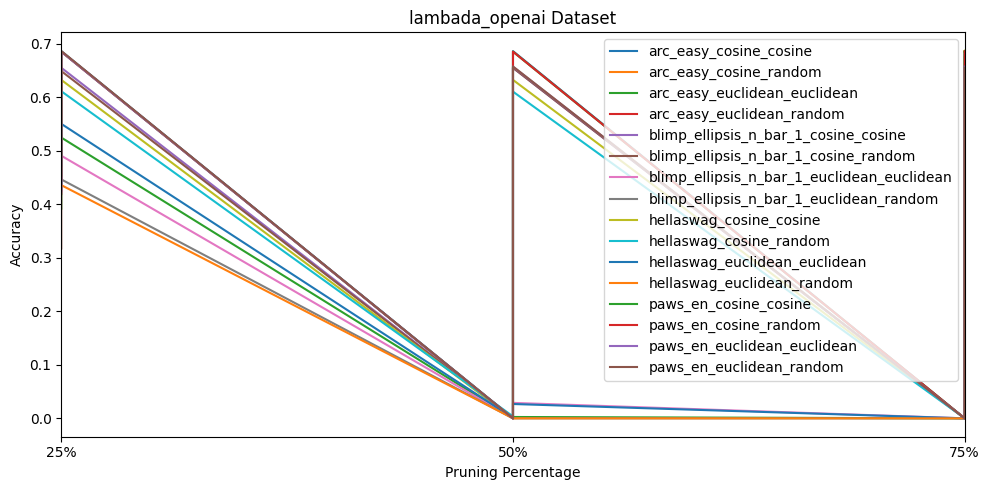

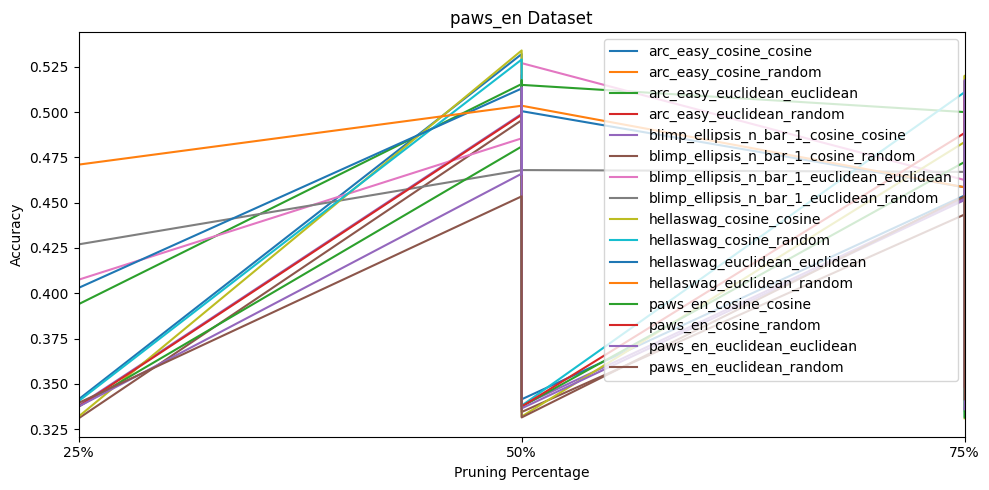

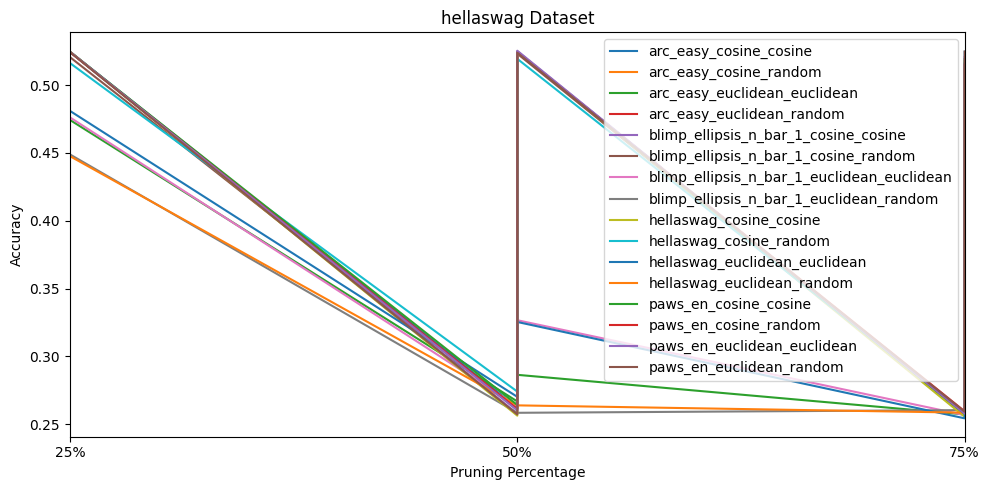

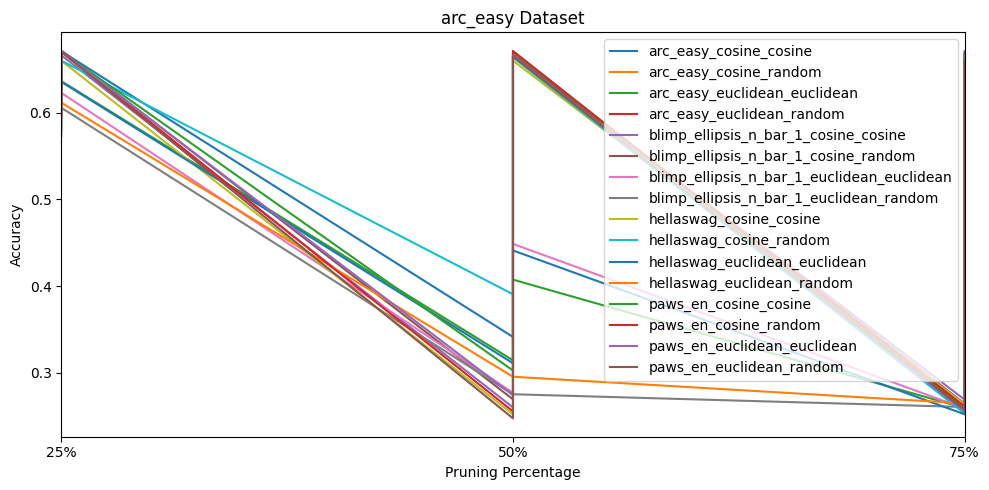

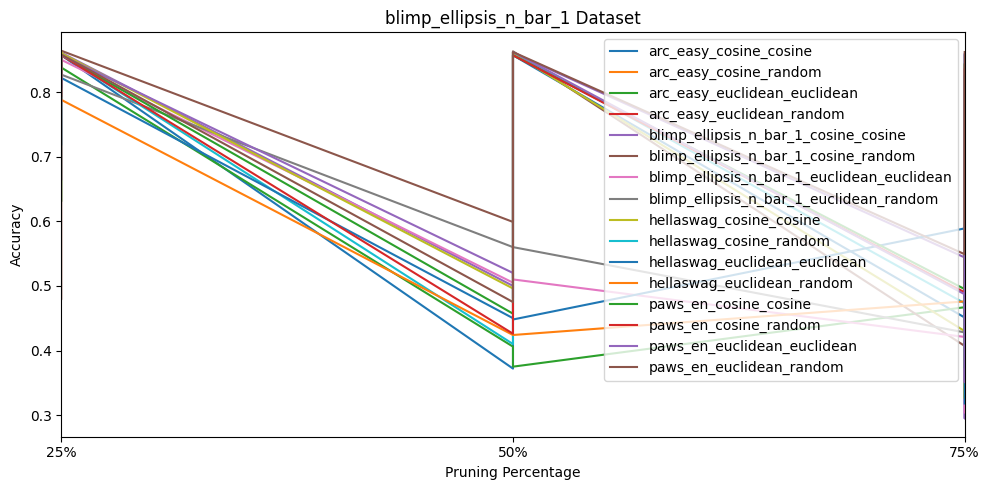

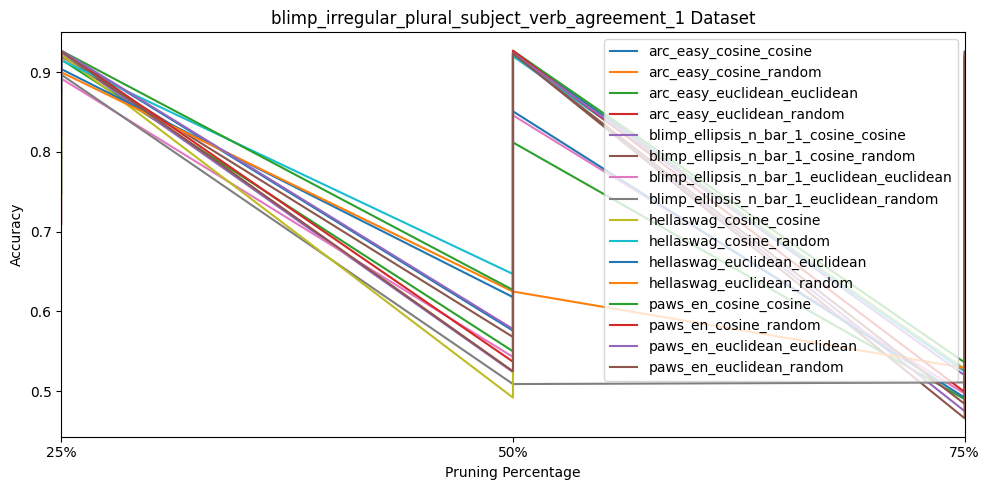

In [105]:
unique_tasks = df['task'].unique()

for task in unique_tasks:
    fig, ax = plt.subplots(figsize=(10, 5))

    task_data = df[df['task'] == task]
    for (prune_task, prune_metric), group_data in task_data.groupby(['prune_task', 'metric']):
        # Creating a unique label for each line
        label = f"{prune_task}_{prune_metric}"
        sorted_data = group_data.sort_values(by='percent')
        ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

    ax.set_title(f'{task} Dataset')
    ax.set_xlabel('Pruning Percentage')
    ax.set_ylabel('Accuracy')
    plt.xticks([0.25, 0.5, 0.75], ['25%', '50%', '75%'])
    # x axis between 0.25 and 0.75
    ax.set_xlim(0.25, 0.75)

    # Creating a legend
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

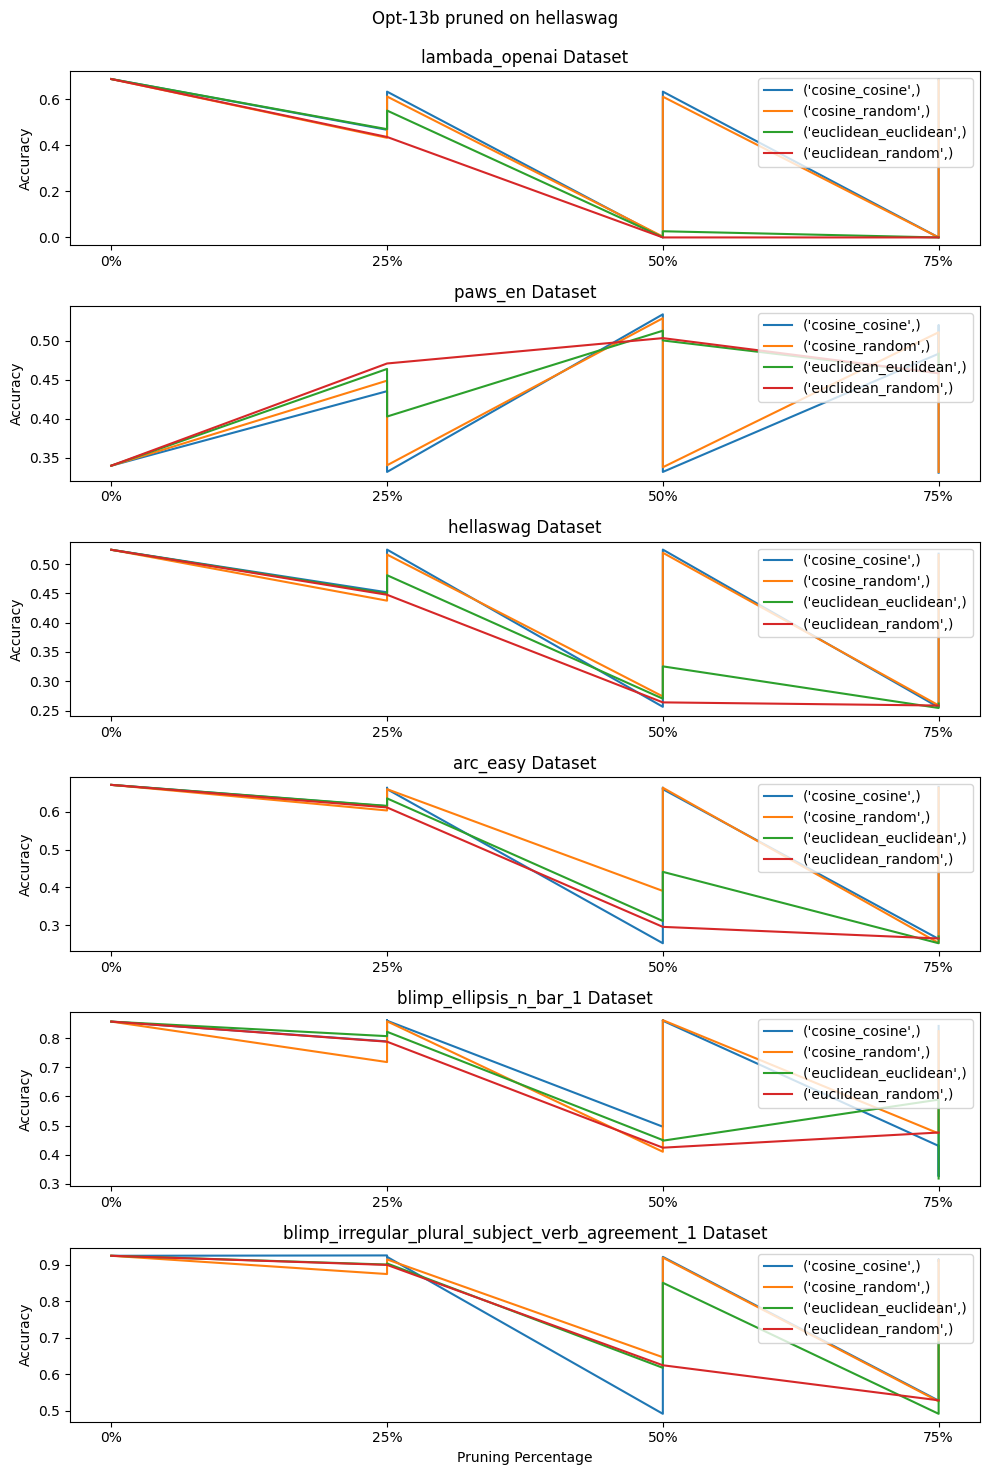

In [104]:
def prune_task_plots(selected_task = 'hellaswag', model='opt-13b'):
    unique_tasks = df['task'].unique()

    # Plotting
    fig, axes = plt.subplots(len(unique_tasks), 1, figsize=(10, 15))

    for i, task in enumerate(unique_tasks):
        hella = df[df['prune_task'] == selected_task]
        task_data = hella[hella['task'] == task]
        for prune_metric, group_data in task_data.groupby(['metric']):
            # Creating a unique label for each line
            label = prune_metric
            sorted_data = group_data.sort_values(by=['metric','percent'])
            axes[i].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

        axes[i].set_title(f'{task} Dataset')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend(loc='upper right')
        axes[i].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

    axes[-1].set_xlabel('Pruning Percentage')

    fig.suptitle(f'{model.capitalize()} pruned on {selected_task}\n')
    plt.tight_layout()
    plt.show()

prune_task_plots(selected_task='hellaswag', model='opt-13b')

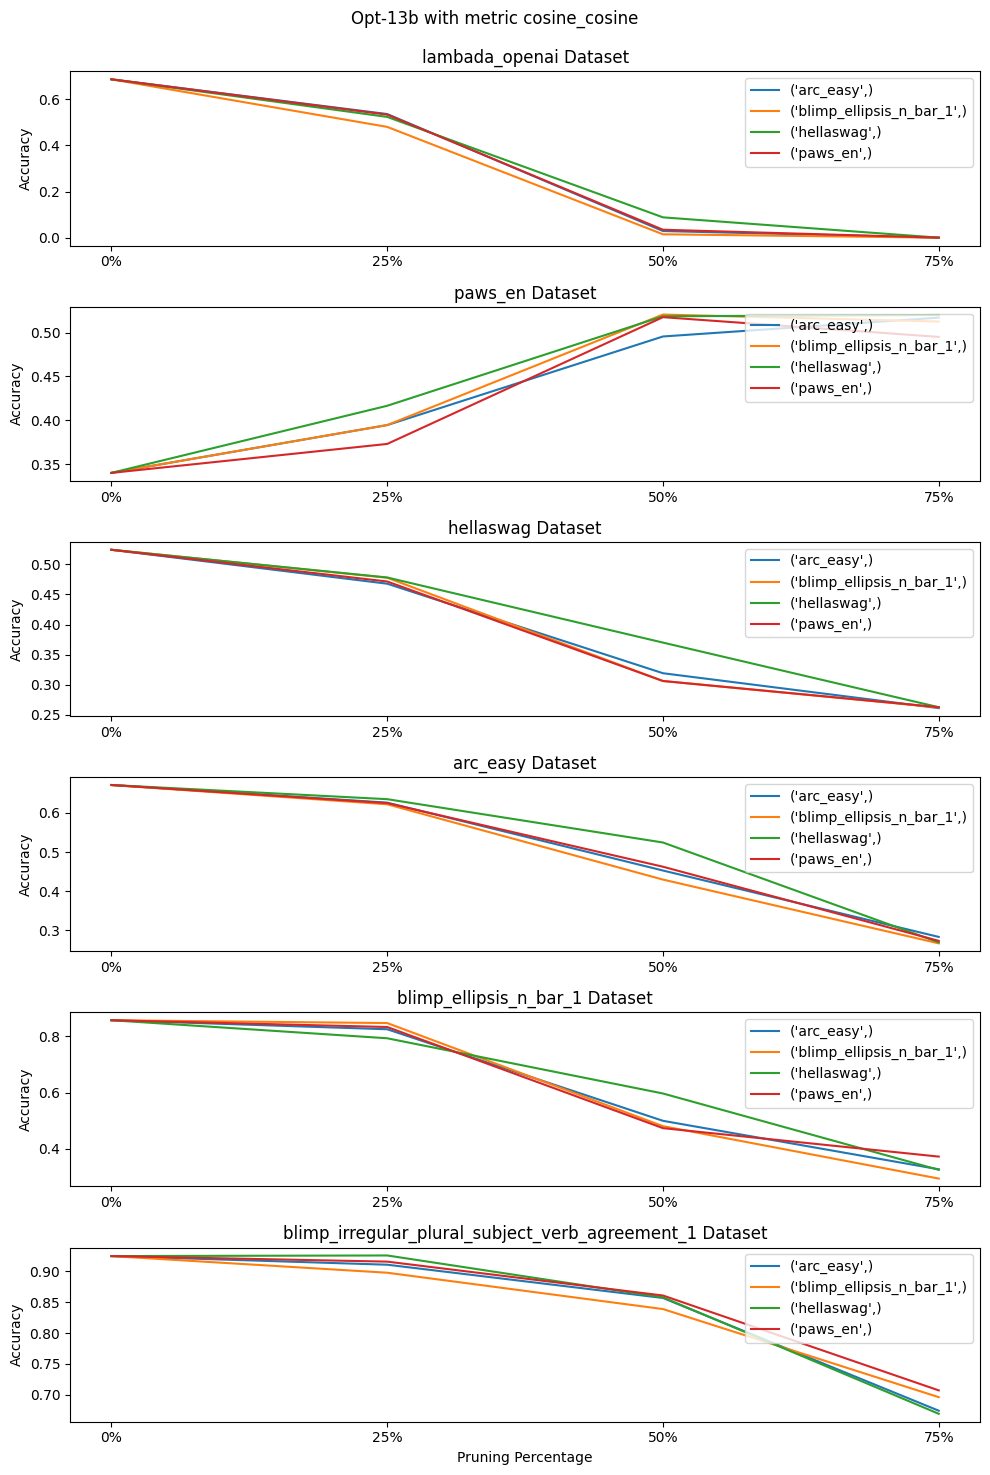

In [6]:
def metric_based_plot(df, prune_metric, model='opt-13b'):
    unique_tasks = df['task'].unique()

    # Plotting
    fig, axes = plt.subplots(len(unique_tasks), 1, figsize=(10, 15))

    for i, task in enumerate(unique_tasks):
        # Filtering the data based on the selected model and metric
        metric_data = df[(df['metric'] == prune_metric) & (df['model'] == model)]
        task_data = metric_data[metric_data['task'] == task]

        for prune_task, group_data in task_data.groupby(['prune_task']):
            # Creating a unique label for each line
            label = prune_task
            sorted_data = group_data.sort_values(by=['percent'])
            axes[i].plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=label)

        axes[i].set_title(f'{task} Dataset')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend(loc='upper right')
        axes[i].set_xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])

    axes[-1].set_xlabel('Pruning Percentage')
    fig.suptitle(f'{model.capitalize()} with metric {prune_metric}\n')
    plt.tight_layout()
    plt.show()

metric_based_plot(df[df['prune_method'] == 'balanced_mask'], prune_metric='cosine_cosine', model='opt-13b')

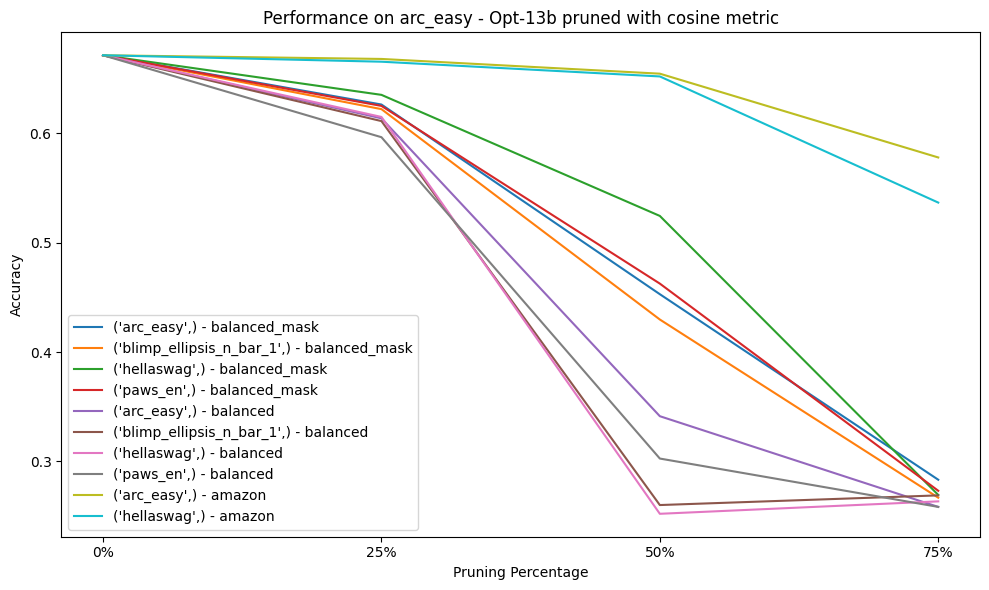

In [103]:
def plot_task_comparison(df, task, prune_metric, prune_methods = ['balanced_mask', 'balanced', 'amazon'], model='opt-13b'):
    plt.figure(figsize=(10, 6))

    for prune_method in prune_methods:
        # Filtering data based on task, prune method, metric, and model
        task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                       ((df['metric'] == prune_metric) | (df['metric'] == 'amazon')) & (df['model'] == model)]

        for prune_task, group_data in task_data.groupby(['prune_task']):
            # Sort and plot each group
            sorted_data = group_data.sort_values(by=['percent'])
            plt.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{prune_task} - {prune_method}')

    # Setting plot details
    plt.title(f'Performance on {task} - {model.capitalize()} pruned with {prune_metric.split("_")[0]} metric')
    plt.xlabel('Pruning Percentage')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower left')
    plt.xticks([0, 0.25, 0.5, 0.75], ['0%', '25%', '50%', '75%'])
    plt.tight_layout()
    plt.show()

# Call the function for a specific task
plot_task_comparison(df_final, task='arc_easy', prune_metric='cosine_cosine', model='opt-13b')

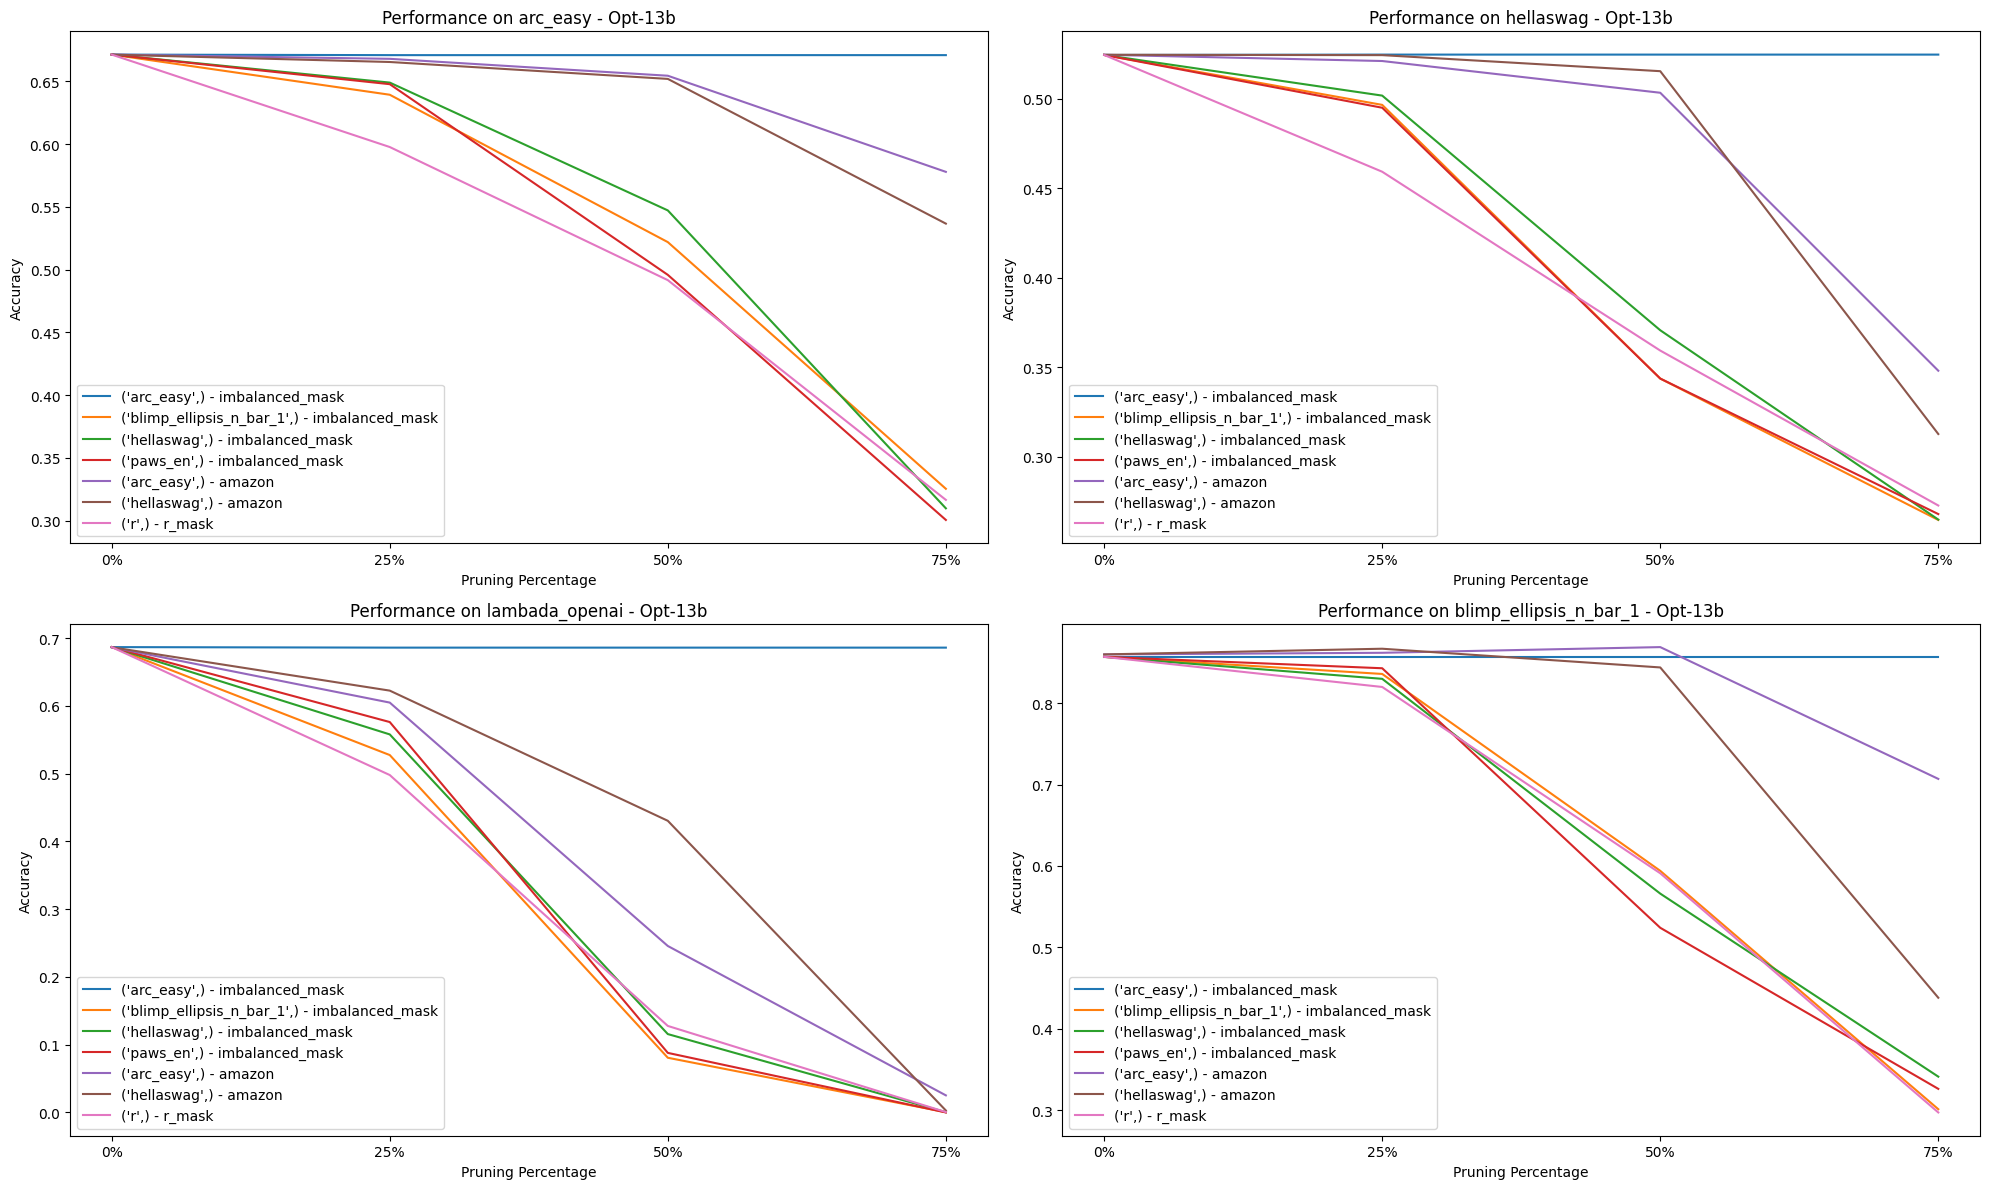

In [52]:
def plot_task_comparisons(df, tasks, prune_metric, prune_methods=['imbalanced_mask', 'amazon', 'r_mask'], model='opt-13b'):
    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    # Iterate over the list of tasks and the axes simultaneously
    for ax, task in zip(axes, tasks):
        for prune_method in prune_methods:
            # Filtering data based on task, prune method, metric, and model
            task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                           ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'r')) & (df['model'] == model)]

            for prune_task, group_data in task_data.groupby(['prune_task']):
                # Sort and plot each group
                sorted_data = group_data.sort_values(by=['percent'])
                ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{prune_task} - {prune_method}')

        # Setting plot details for each subplot
        ax.set_title(f'Performance on {task} - {model.capitalize()}')
        ax.set_xlabel('Pruning Percentage')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower left')
        ax.set_xticks([0, 0.25, 0.5, 0.75])
        ax.set_xticklabels(['0%', '25%', '50%', '75%'])

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_task_comparisons(df_final, tasks = ['arc_easy', 'hellaswag', 'lambada_openai', 'blimp_ellipsis_n_bar_1'], prune_metric='cosine_cosine', model='opt-13b')


In [94]:
df_final[df_final['prune_method'] == 'imbalanced_mask'].head(50)

model prune_method prune_task  metric  percent  \
0   opt-13b       amazon   arc_easy  amazon     0.00   
1   opt-13b       amazon   arc_easy  amazon     0.00   
2   opt-13b       amazon   arc_easy  amazon     0.00   
3   opt-13b       amazon   arc_easy  amazon     0.00   
4   opt-13b       amazon   arc_easy  amazon     0.00   
5   opt-13b       amazon   arc_easy  amazon     0.25   
6   opt-13b       amazon   arc_easy  amazon     0.25   
7   opt-13b       amazon   arc_easy  amazon     0.25   
8   opt-13b       amazon   arc_easy  amazon     0.25   
9   opt-13b       amazon   arc_easy  amazon     0.25   
10  opt-13b       amazon   arc_easy  amazon     0.50   
11  opt-13b       amazon   arc_easy  amazon     0.50   
12  opt-13b       amazon   arc_easy  amazon     0.50   
13  opt-13b       amazon   arc_easy  amazon     0.50   
14  opt-13b       amazon   arc_easy  amazon     0.50   
15  opt-13b       amazon   arc_easy  amazon     0.75   
16  opt-13b       amazon   arc_easy  amazon     0.75   
17  opt-13b       amazon   arc_easy  amazon     0.75   
18  opt-13b       amazon   arc_easy  amazon     0.75   
19  opt-13b       amazon   arc_easy  amazon     0.75   
20  opt-13b       amazon  hellaswag  amazon     0.00   
21  opt-13b       amazon  hellaswag  amazon     0.00   
22  opt-13b       amazon  hellaswag  amazon     0.00   
23  opt-13b       amazon  hellaswag  amazon     0.00   
24  opt-13b       amazon  hellaswag  amazon     0.00   
25  opt-13b       amazon  hellaswag  amazon     0.25   
26  opt-13b       amazon  hellaswag  amazon     0.25   
27  opt-13b       amazon  hellaswag  amazon     0.25   
28  opt-13b       amazon  hellaswag  amazon     0.25   
29  opt-13b       amazon  hellaswag  amazon     0.25   
30  opt-13b       amazon  hellaswag  amazon     0.50   
31  opt-13b       amazon  hellaswag  amazon     0.50   
32  opt-13b       amazon  hellaswag  amazon     0.50   
33  opt-13b       amazon  hellaswag  amazon     0.50   
34  opt-13b       amazon  hellaswag  amazon     0.50   
35  opt-13b       amazon  hellaswag  amazon     0.75   
36  opt-13b       amazon  hellaswag  amazon     0.75   
37  opt-13b       amazon  hellaswag  amazon     0.75   
38  opt-13b       amazon  hellaswag  amazon     0.75   
39  opt-13b       amazon  hellaswag  amazon     0.75   

                                               task  norm_accuracy  
0                            blimp_ellipsis_n_bar_1       0.860000  
1   blimp_irregular_plural_subject_verb_agreement_1       0.925000  
2                                           lambada       0.686590  
3                                         hellaswag       0.524497  
4                                          arc_easy       0.671296  
5                            blimp_ellipsis_n_bar_1       0.862000  
6                                          arc_easy       0.667929  
7                                         hellaswag       0.521012  
8                                           lambada       0.604890  
9   blimp_irregular_plural_subject_verb_agreement_1       0.925000  
10  blimp_irregular_plural_subject_verb_agreement_1       0.922000  
11                                          lambada       0.245682  
12                                        hellaswag       0.503286  
13                                         arc_easy       0.654461  
14                           blimp_ellipsis_n_bar_1       0.869000  
15  blimp_irregular_plural_subject_verb_agreement_1       0.914000  
16                                        hellaswag       0.348038  
17                                          lambada       0.025228  
18                           blimp_ellipsis_n_bar_1       0.707000  
19                                         arc_easy       0.577862  
20                           blimp_ellipsis_n_bar_1       0.860000  
21                                        hellaswag       0.524497  
22                                          lambada       0.686590  
23                                         arc_easy  

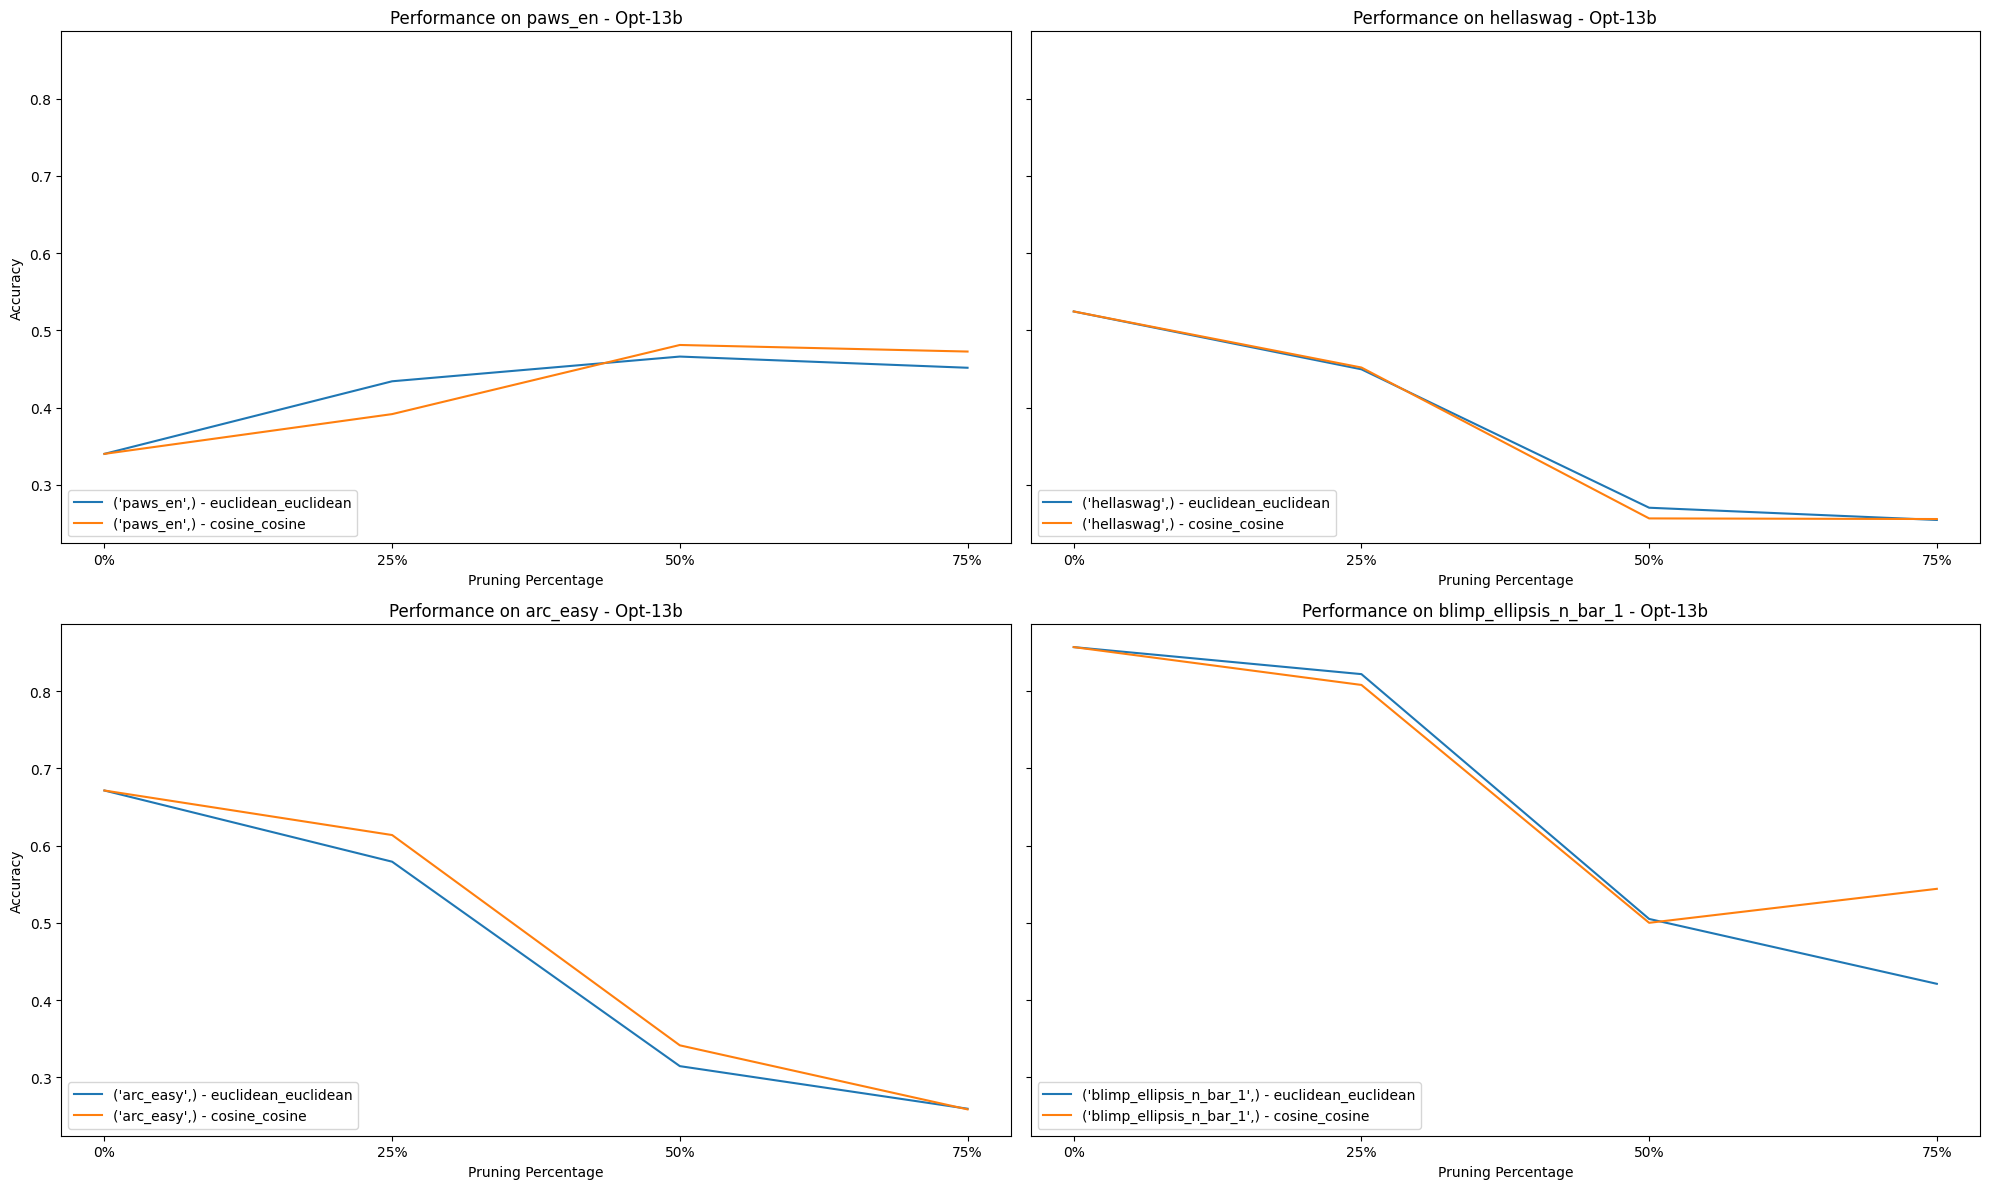

In [76]:
def plot_metric_comparison(df, tasks, prune_metrics=['euclidean_euclidean', 'cosine_cosine'], prune_methods=["balanced"], model='opt-13b'):
    
    # Create a 2x2 figure grid for subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), sharey=True)
    axes = axes.flatten()  # Flatten the 2x2 array to easily iterate over it
    
    for ax, task in zip(axes, tasks):
        for prune_method in prune_methods:
            for prune_metric in prune_metrics:
                # Filtering data based on task, prune method, metric, and model
                task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                            ((df['metric'] == prune_metric) | (df['metric'] == 'amazon')) & 
                            (df['model'] == model) & (df['prune_task'] == task)]

                for prune_task, group_data in task_data.groupby(['prune_task']):
                    # Sort and plot each group
                    sorted_data = group_data.sort_values(by=['percent'])
                    ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{prune_task} - {prune_metric}')

        # Setting subplot details
        ax.set_title(f'Performance on {task} - {model.capitalize()}')
        ax.set_xlabel('Pruning Percentage')
        if ax in [axes[0], axes[2]]:  # Add y-axis labels only to the first column subplots
            ax.set_ylabel('Accuracy')
        ax.legend(loc='lower left')
        ax.set_xticks([0, 0.25, 0.5, 0.75])
        ax.set_xticklabels(['0%', '25%', '50%', '75%'])

    plt.tight_layout()
    plt.show()

# Example call for a specific list of tasks
plot_metric_comparison(df_final, tasks=list(df_final['prune_task'].unique()), model='opt-13b')

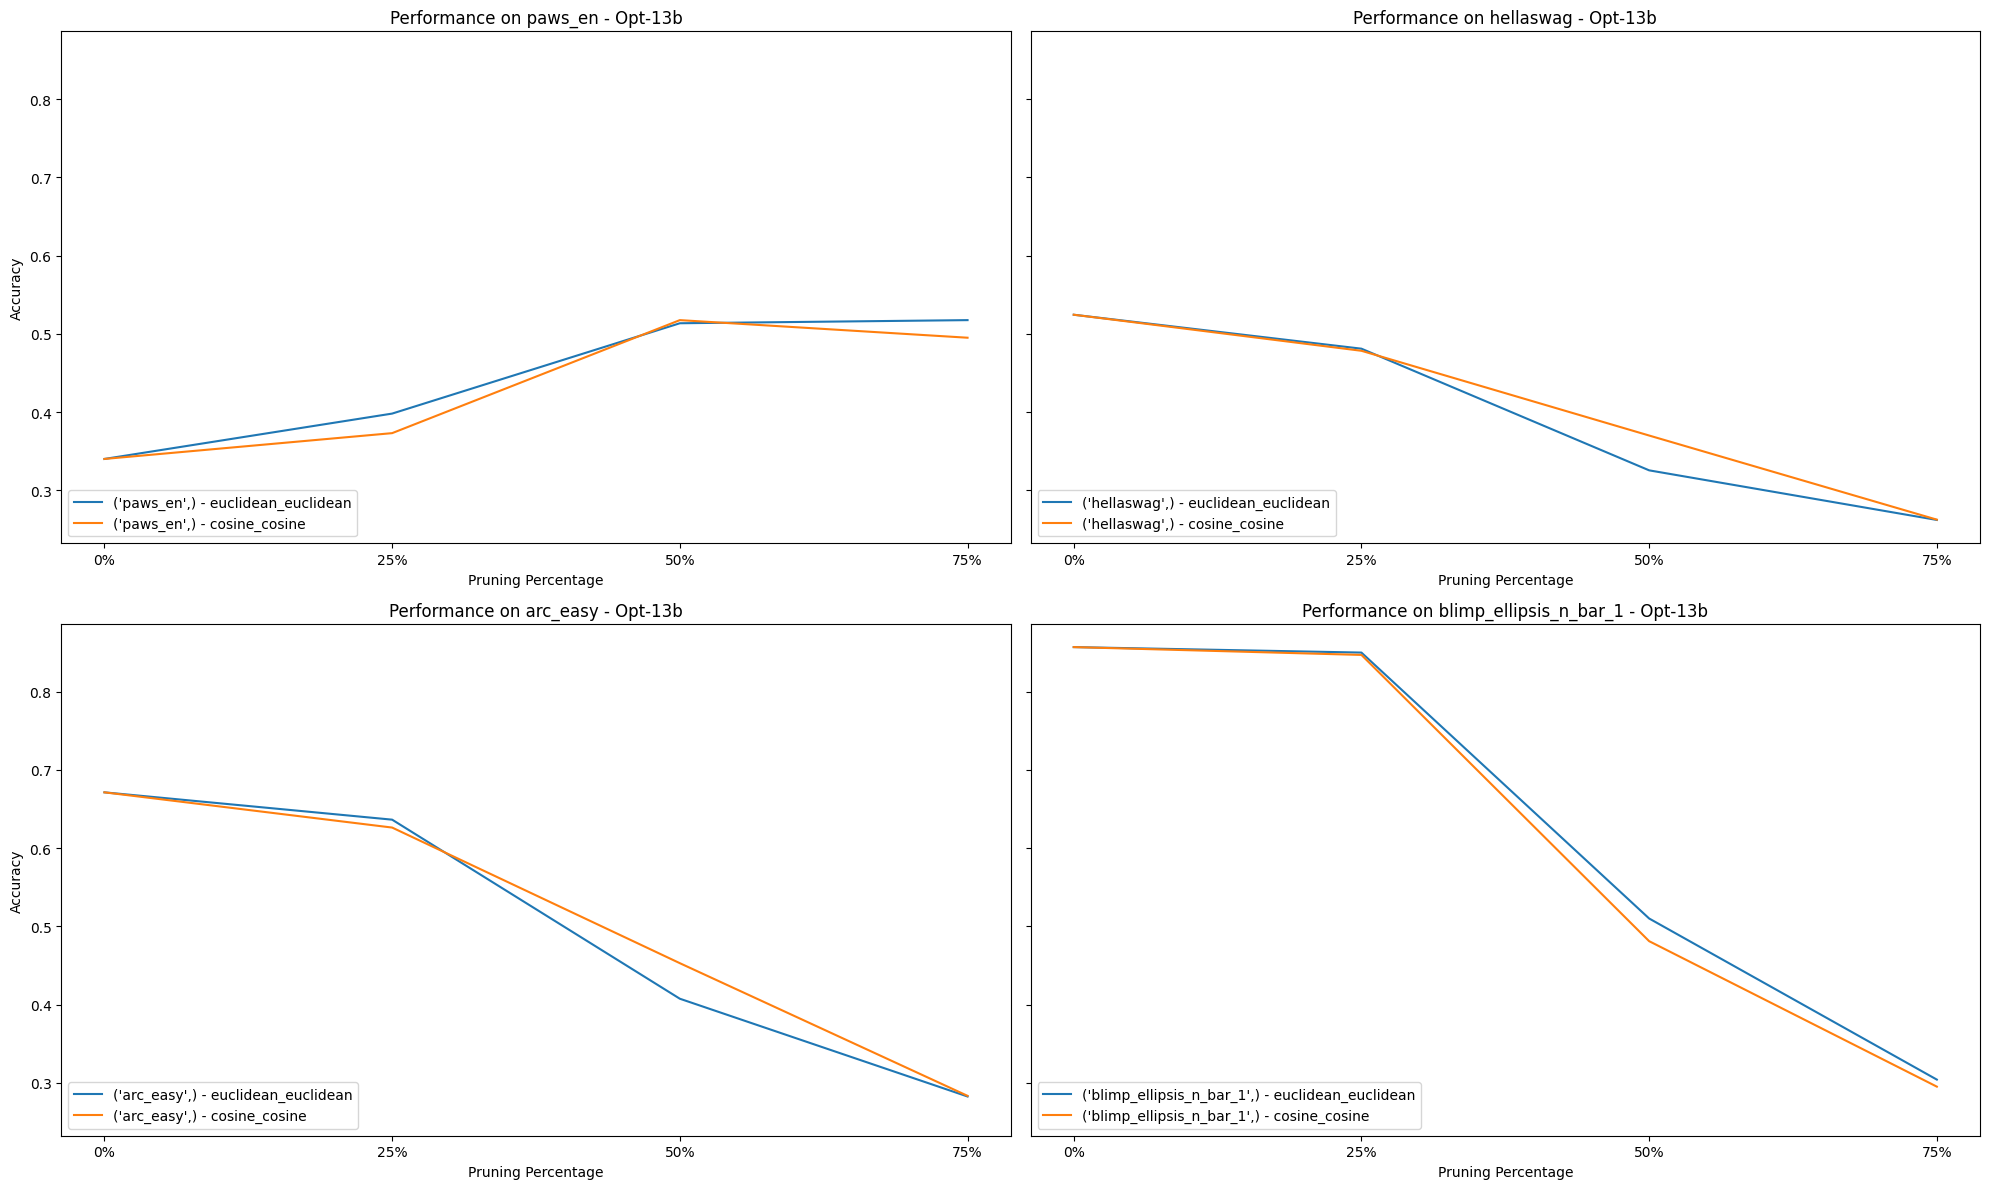

In [85]:
plot_metric_comparison(df_final, tasks=list(df_final['prune_task'].unique()), prune_methods=['balanced_mask'])

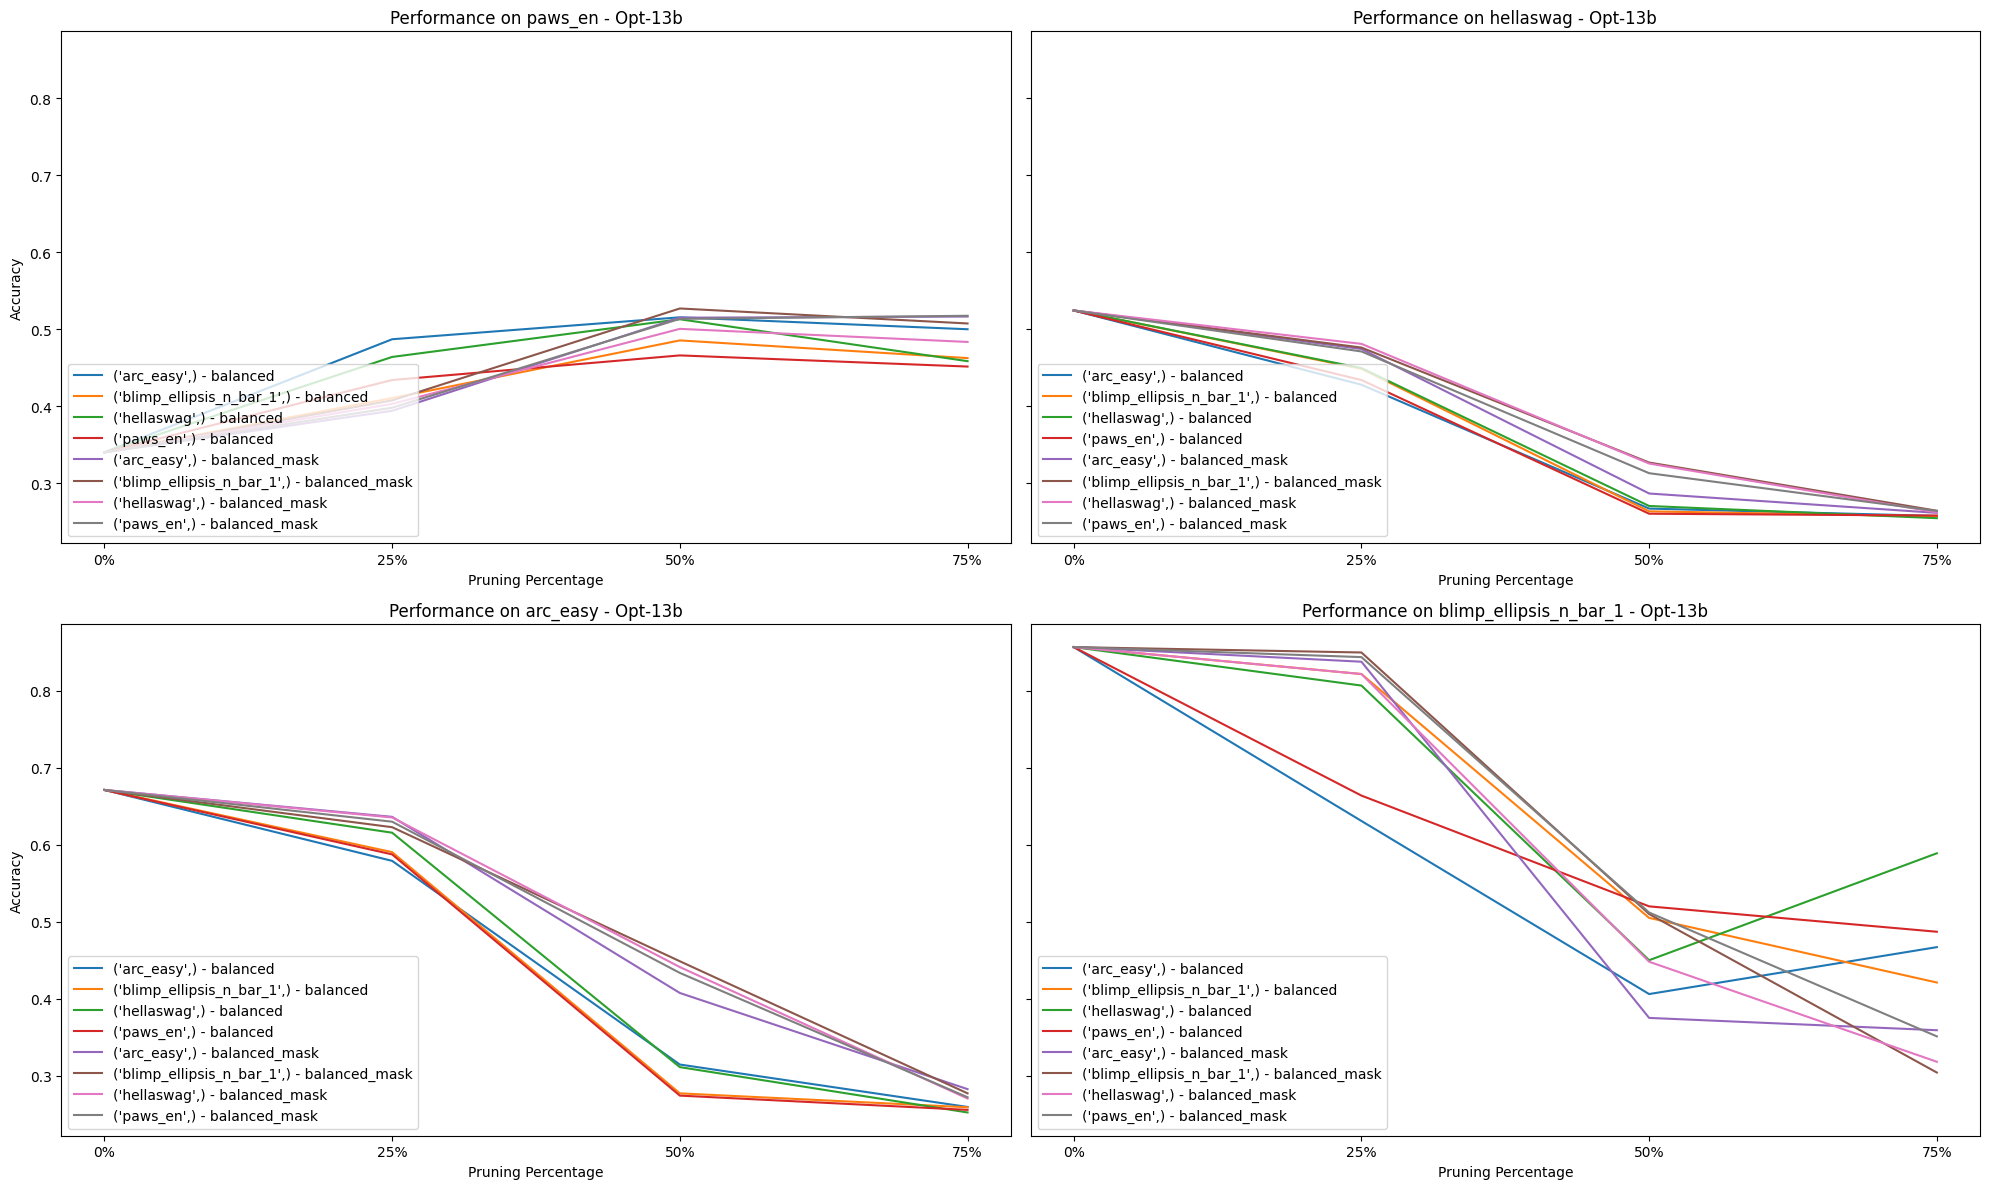

In [34]:
def plot_prune_comparison(df, tasks, prune_metrics=['euclidean_euclidean'], prune_methods=["balanced", "balanced_mask"], model='opt-13b'):
    
    # Create a 2x2 figure grid for subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12), sharey=True)
    axes = axes.flatten()  # Flatten the 2x2 array to easily iterate over it
    
    for ax, task in zip(axes, tasks):
        for prune_method in prune_methods:
            for prune_metric in prune_metrics:
                # Filtering data based on task, prune method, metric, and model
                task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                            ((df['metric'] == prune_metric) | (df['metric'] == 'amazon')) & 
                            (df['model'] == model) ]#& (df['prune_task'] == task)]

                for prune_task, group_data in task_data.groupby(['prune_task']):
                    # Sort and plot each group
                    sorted_data = group_data.sort_values(by=['percent'])
                    ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{prune_task} - {prune_method}')

        # Setting subplot details
        ax.set_title(f'Performance on {task} - {model.capitalize()}')
        ax.set_xlabel('Pruning Percentage')
        if ax in [axes[0], axes[2]]:  # Add y-axis labels only to the first column subplots
            ax.set_ylabel('Accuracy')
        ax.legend(loc='lower left')
        ax.set_xticks([0, 0.25, 0.5, 0.75])
        ax.set_xticklabels(['0%', '25%', '50%', '75%'])

    plt.tight_layout()
    plt.show()

# Example call for a specific list of tasks
plot_prune_comparison(df_final, tasks=list(df_final['prune_task'].unique()), model='opt-13b')

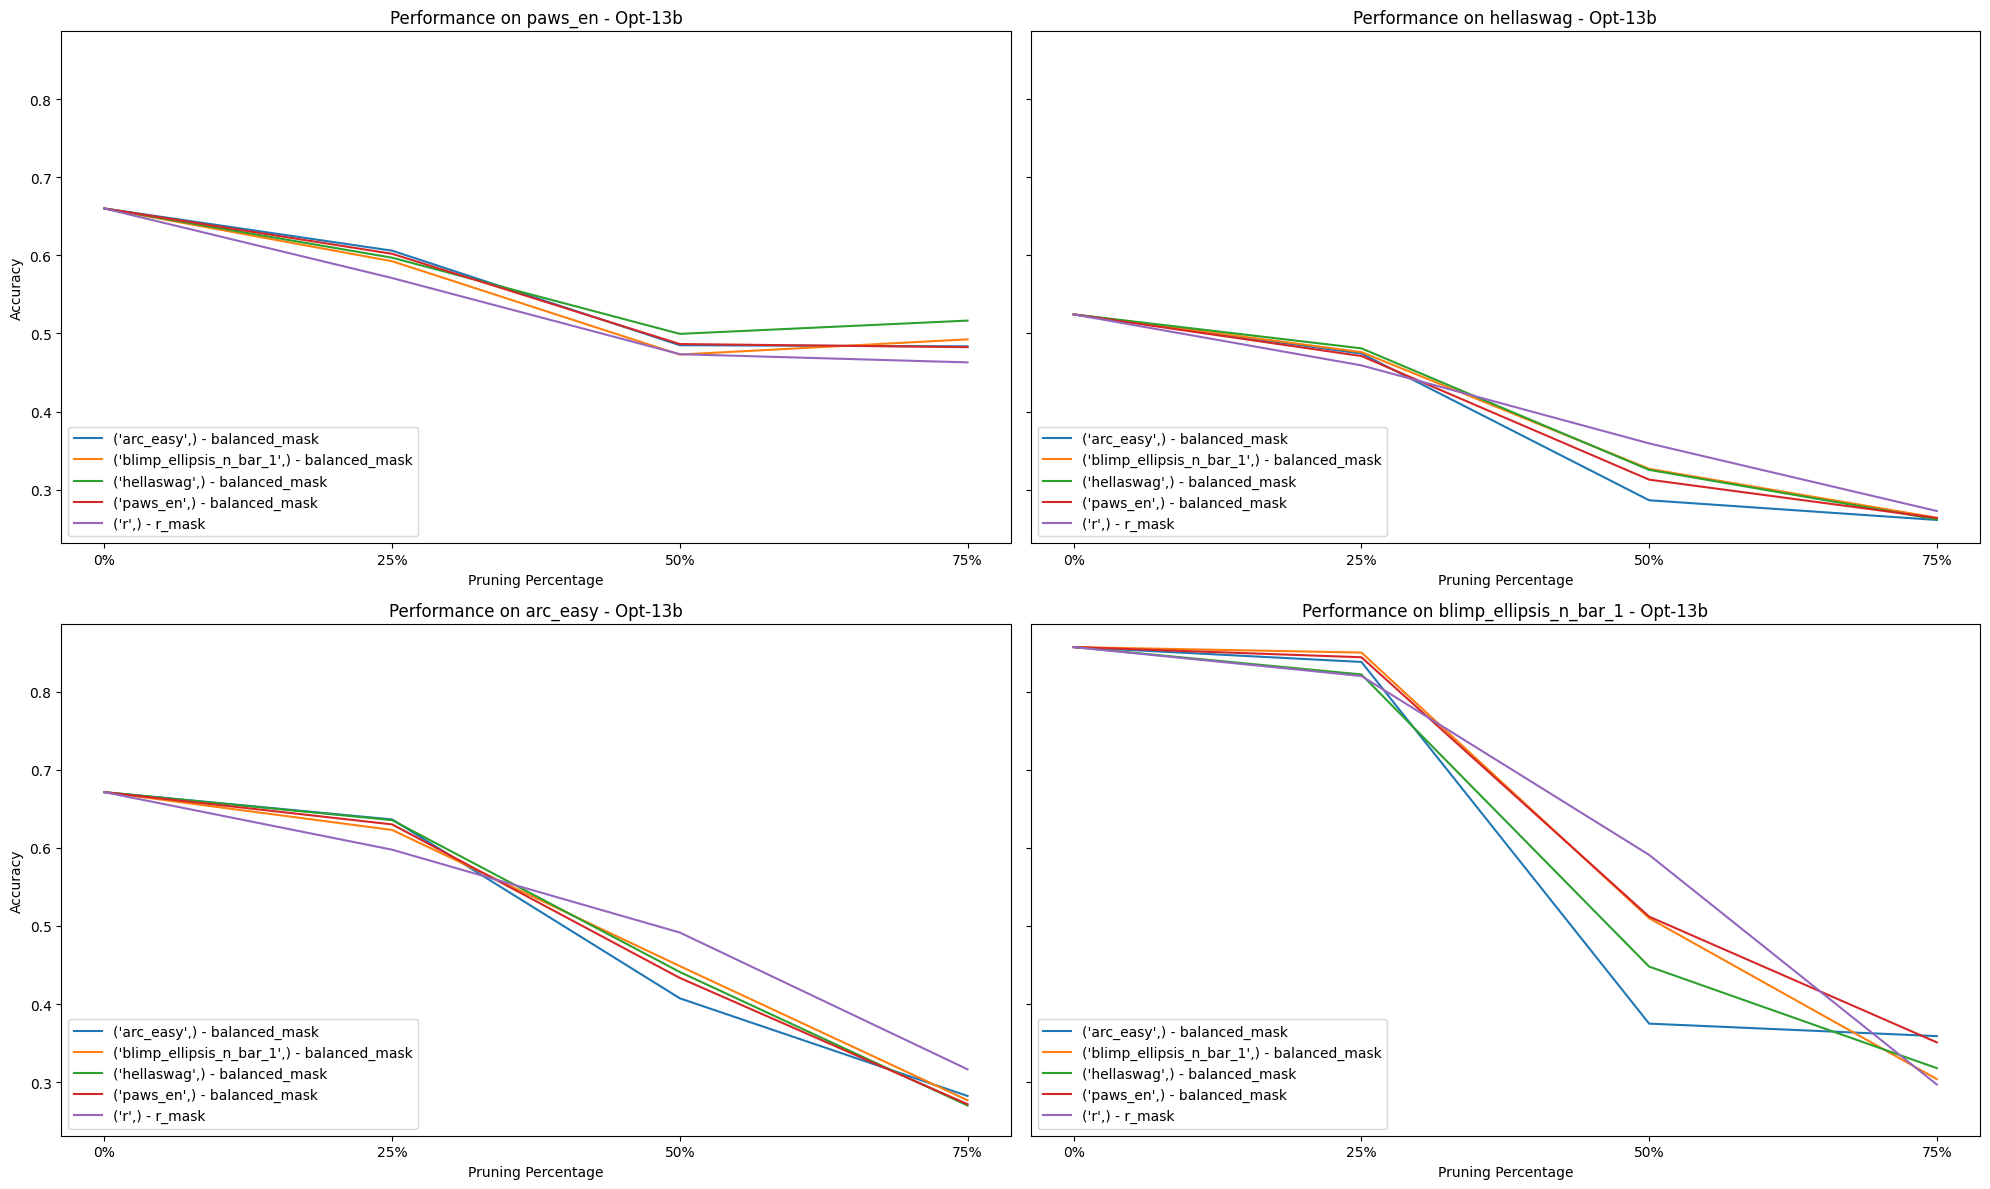

In [41]:
plot_prune_comparison(df_final, tasks=list(df_final['prune_task'].unique()), prune_metrics=["euclidean_euclidean", "r"], prune_methods=['balanced_mask','r_mask'], model='opt-13b')

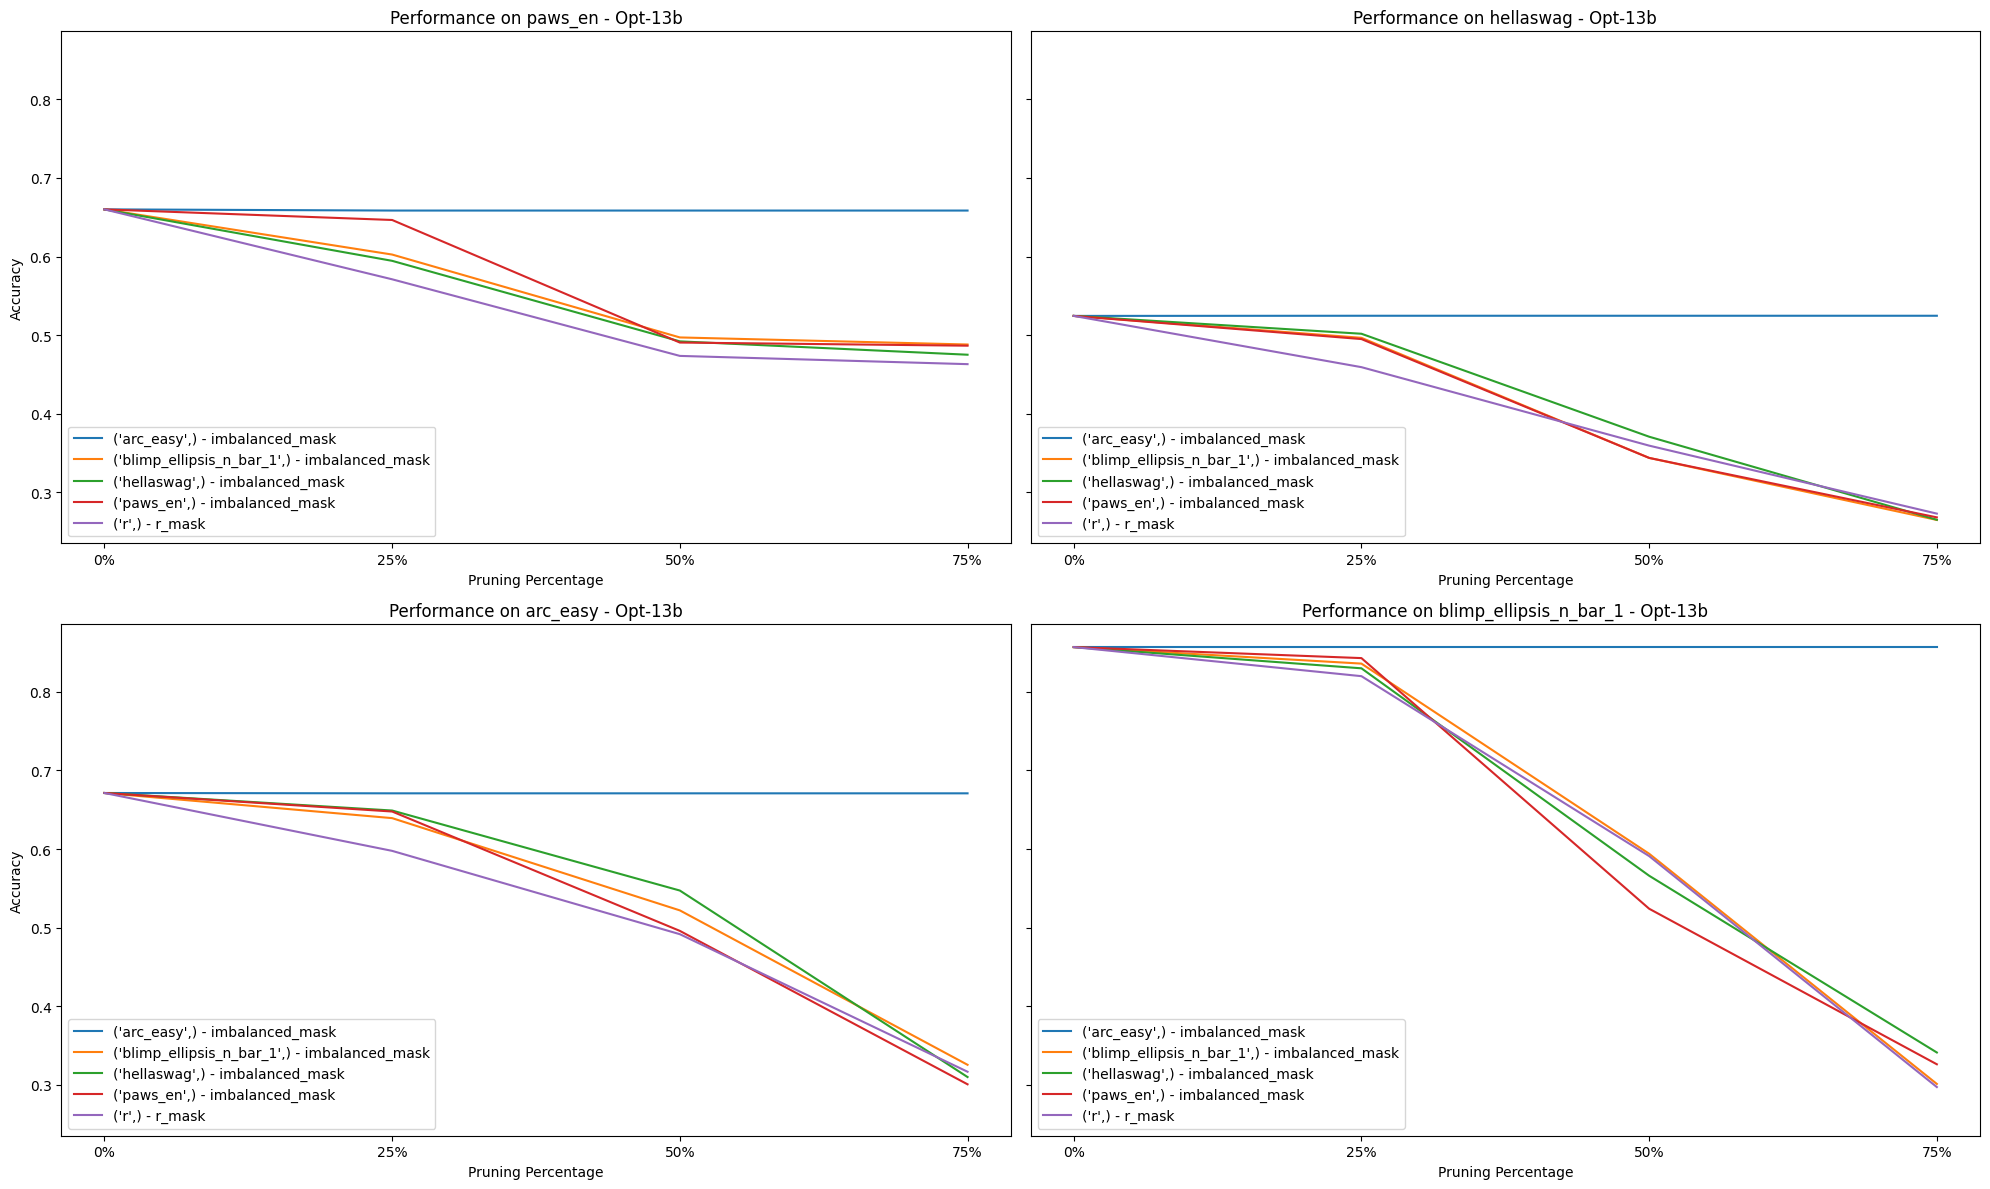

In [46]:
plot_prune_comparison(df_final, tasks=list(df_final['prune_task'].unique()), prune_metrics=["cosine_cosine", "r"], prune_methods=['imbalanced_mask','r_mask'], model='opt-13b')

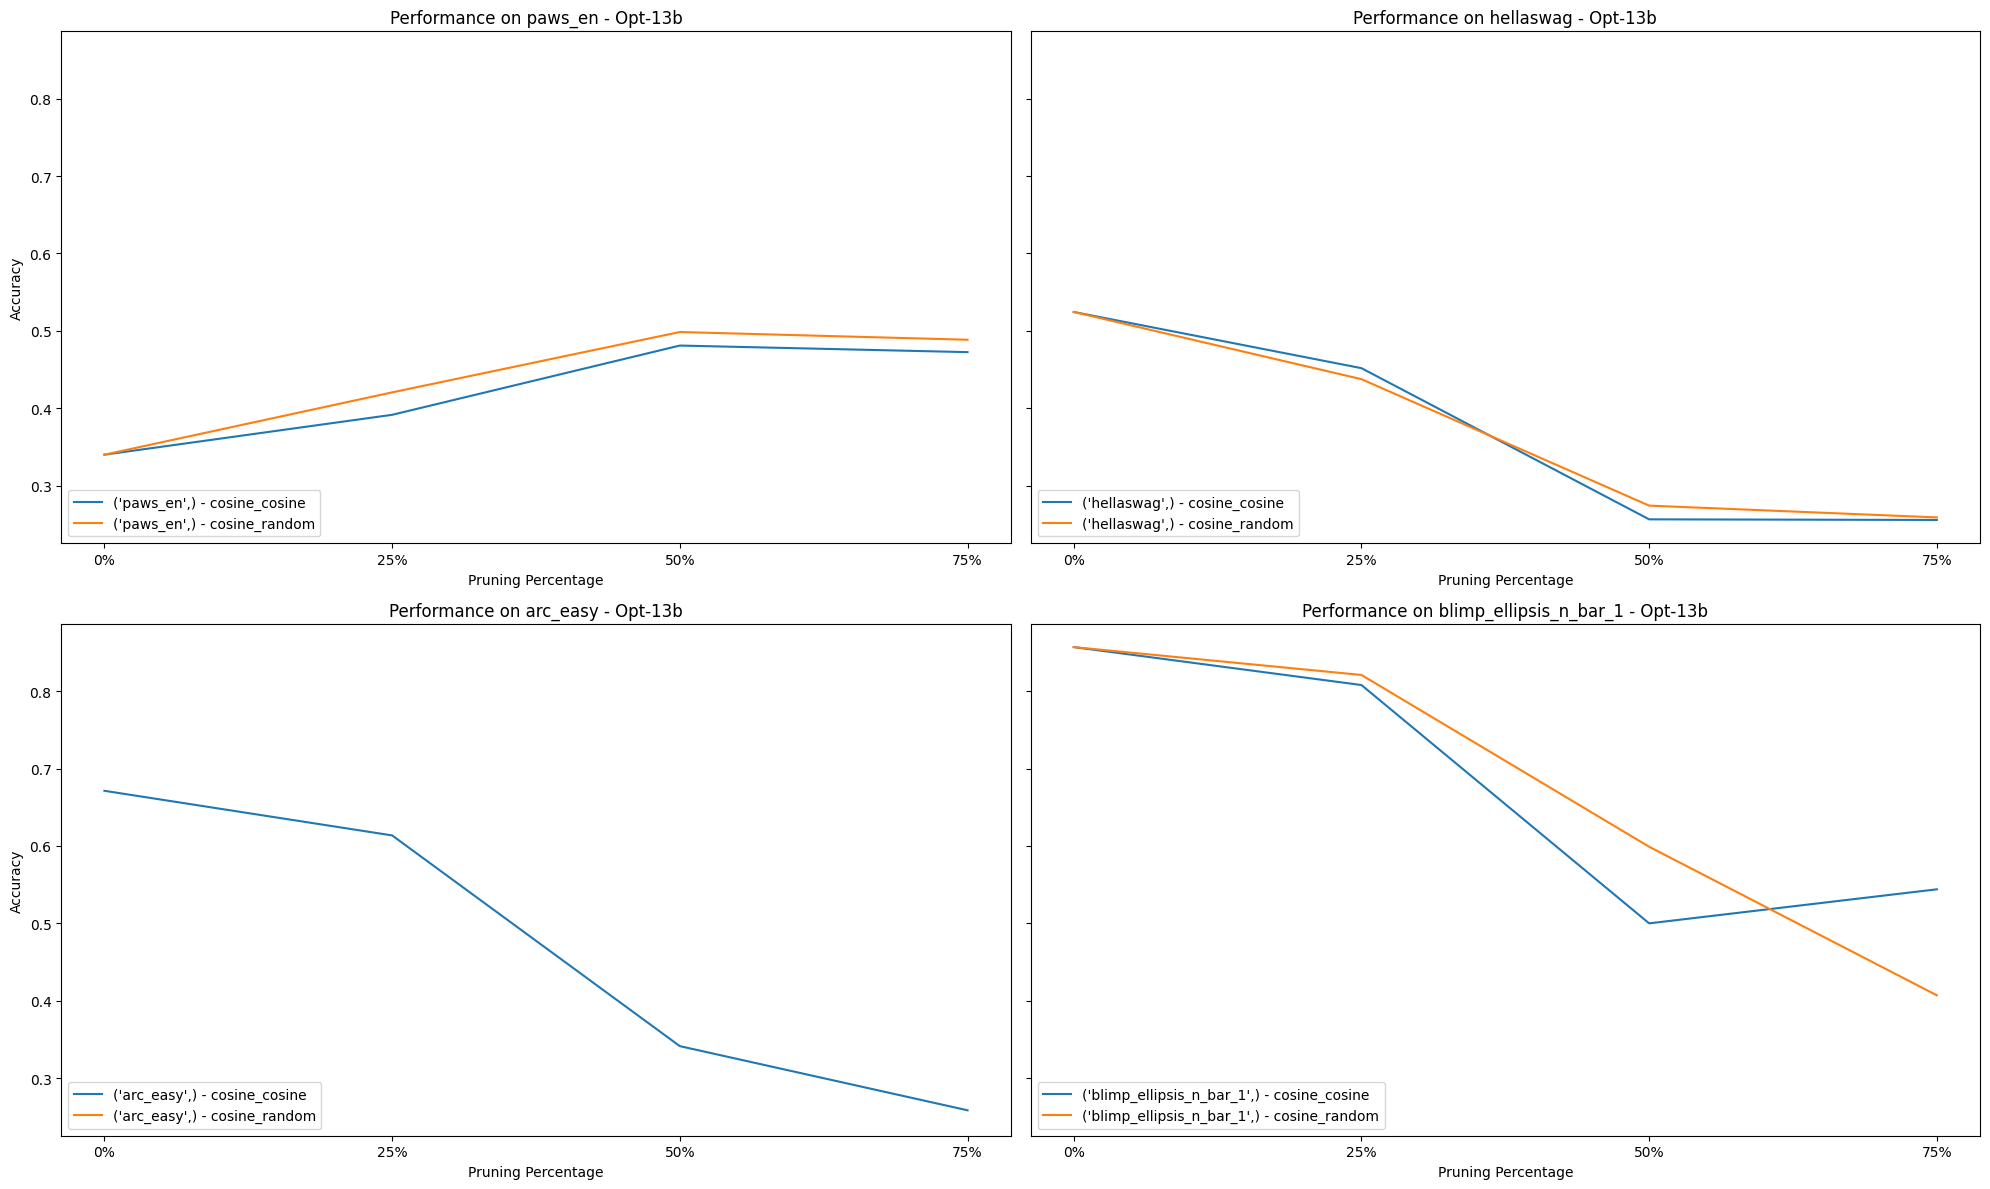

In [59]:
plot_task_comparison(df_final, tasks=list(df_final['prune_task'].unique()), prune_metrics=['cosine_cosine', 'cosine_random'], model='opt-13b')